In [327]:
import os
from argparse import Namespace
import json

import pandas as pd
import matplotlib.pyplot as plt
from torch.nn import functional as fnn

from train import main

In [328]:
#!g1.1

# loss_fn_lst = [fnn.l1_loss, fnn.smooth_l1_loss]#, fnn.mse_loss]

i=0
for w in [4, 5]:
    for e in [0.5, 1, 2, 3]:
        i += 1
        print(f'iteration_{i} w={w}, e={e}')
        request = Namespace(
            name=f'resnext50_wing_loss_w{w}_e{e}_16000_10',
            data_folder='data',
            data_size=16_000,
            crop_size=256,
            batch_size=64,
            epochs=10,
            learning_rate=0.001,
            gpu=True,
            worker=1
        )
        main(request, w, e)

validation...: 100%|██████████| 50/50 [00:14<00:00,  3.50it/s]


iteration_1 w=4, e=0.5
Reading data...
Creating model resnext50_32x4d...

Tune optimizer...
Use wing loss!
Ready for training...
Epoch # 0:	train loss: 3.7e+01	val loss: 1.1e+02
Epoch # 1:	train loss: 1.1e+01	val loss: 8.3e+01
Epoch # 2:	train loss:   9.6	val loss: 4.9e+01
Epoch # 3:	train loss:   8.5	val loss: 3.2e+01
Epoch # 4:	train loss:   8.1	val loss: 2.7e+01
Epoch # 5:	train loss:   7.9	val loss: 3e+01
Epoch # 6:	train loss:   7.7	val loss: 2.3e+01
Epoch # 7:	train loss:   7.6	val loss: 2.4e+01
Epoch # 8:	train loss:   7.5	val loss: 2.2e+01
Epoch # 9:	train loss:   7.3	val loss: 2.2e+01
iteration_2 w=4, e=1
Reading data...
Creating model resnext50_32x4d...
Tune optimizer...
Use wing loss!
Ready for training...
Epoch # 0:	train loss: 3.5e+01	val loss: 1.1e+02
Epoch # 1:	train loss:   8.9	val loss: 9.5e+01
Epoch # 2:	train loss:   8.3	val loss: 5.8e+01
Epoch # 3:	train loss:   6.8	val loss: 3.2e+01
Epoch # 4:	train loss:   6.1	val loss: 2.8e+01
Epoch # 5:	train loss:   5.8	val los

In [ ]:
#!g1.1


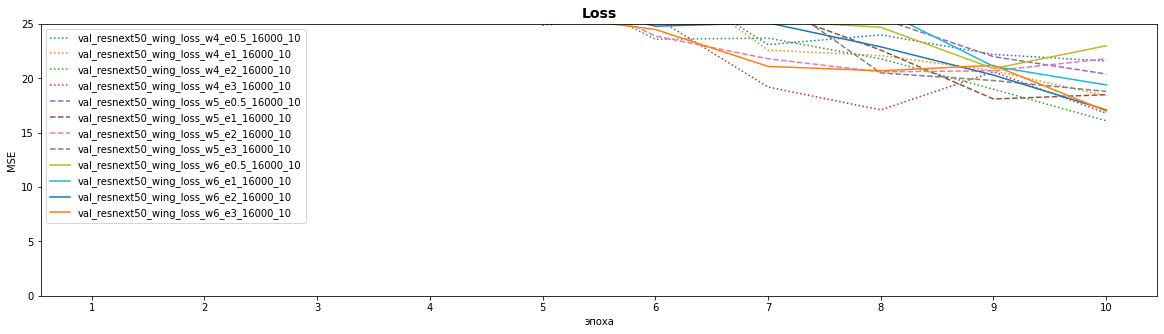

/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:828: UserWarning: The following variables cannot be serialized: f
  warnings.warn(message)


In [330]:
# figure
plt.figure(figsize=(20, 5)) 
ax = plt.axes() # Add an axes to the current figure and make it the current axes

# for experiment in [
#     'resnext50_wing_loss_w6_e2_16000_10',
#     'resnext50_wing_loss_w6_e3_16000_10',
#     'resnext50_l1_loss_16000_10'
# ]:
    
for w in [4, 5, 6]:#, 8, 10, 12]:
    for e in [0.5, 1, 2, 3]:
        if w==6: ls = 'solid'
        if w==4: ls = 'dotted'
        if w==5: ls = 'dashed'
        #if w==12: ls = 'dashdot'
        experiment=f'resnext50_wing_loss_w{w}_e{e}_16000_10'
    
        with open(f'runs/{experiment}/metrics_{experiment}.txt') as f:
            metrics = json.load(f)

        # data
        x = range(1, len(metrics['val_loss']) + 1)
        #ls = 'solid' if experiment=='resnext50_l1_loss_16000_10' else 'dotted'
        ax.plot(x, metrics['val_loss'], linestyle=ls, label=f'val_{experiment}')

# annotation    
ax.set_title('Loss', fontsize=14, fontweight='bold')
ax.set_xlabel('эпоха')
ax.set_ylabel('MSE')
ax.legend()
ax.set_xticks(range(1, len(metrics['train_loss']) + 1))
_ = ax.set_ylim([0, 25])

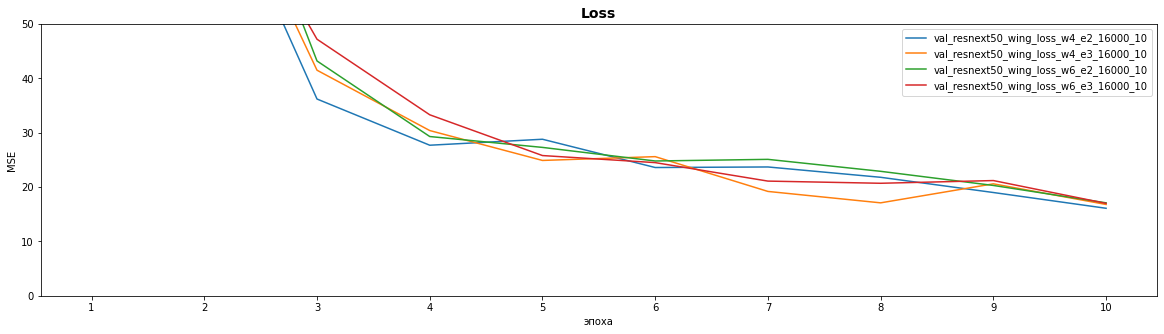

/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:828: UserWarning: The following variables cannot be serialized: f
  warnings.warn(message)


In [332]:
# figure
plt.figure(figsize=(20, 5)) 
ax = plt.axes() # Add an axes to the current figure and make it the current axes


    
for w, e in [(4, 2), (4, 3), (6, 2), (6, 3)]:

    experiment=f'resnext50_wing_loss_w{w}_e{e}_16000_10'

    with open(f'runs/{experiment}/metrics_{experiment}.txt') as f:
        metrics = json.load(f)

    # data
    x = range(1, len(metrics['val_loss']) + 1)
    #ls = 'solid' if experiment=='resnext50_l1_loss_16000_10' else 'dotted'
    ax.plot(x, metrics['val_loss'], linestyle=ls, label=f'val_{experiment}')

# annotation    
ax.set_title('Loss', fontsize=14, fontweight='bold')
ax.set_xlabel('эпоха')
ax.set_ylabel('MSE')
ax.legend()
ax.set_xticks(range(1, len(metrics['train_loss']) + 1))
_ = ax.set_ylim([0, 50])